# CNN Test 1



## Mount Drive to Get Data

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# !gdown --id "14SvbQvXc9pjEm4p9dcX7PJwY1HWWkVNj"
# !gdown --id "1slETqeU-UooUk-9Mnf7i0pcweh51oQpN"
# !gdown --id "1slil2CxpowYfsKGo4RmK3vtih-AgwXm2"

## Prevent Collab From Logging Off

To avoid logging out, type ctr+shift+I paste into console:


```
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}setInterval(ClickConnect,60000)
```

With locker, to stop run stopClickConnect():

```
var startClickConnect = function startClickConnect(){
    var clickConnect = function clickConnect(){
        console.log("Connnect Clicked - Start");
        document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
        console.log("Connnect Clicked - End"); 
    };

    var intervalId = setInterval(clickConnect, 60000);

    var stopClickConnectHandler = function stopClickConnect() {
        console.log("Connnect Clicked Stopped - Start");
        clearInterval(intervalId);
        console.log("Connnect Clicked Stopped - End");
    };

    return stopClickConnectHandler;
};

var stopClickConnect = startClickConnect();
```

# Setup

## Imports

In [3]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import sys
import pandas as pd
import re
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math
import time

from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

C:\Users\Joely\anaconda3\envs\comp_genomics\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Joely\anaconda3\envs\comp_genomics\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [73]:
def time_str(secs):
    '''
    Given a time in seconds, prints the format in xh ym zs
    '''
    p_secs = int(secs % 60)
    p_mins = int((secs // 60) % 60)
    p_hours = int((secs // 60 // 60))
    
    return str(p_hours) + "h " + str(p_mins) + "m " + str(p_secs) + "s"
    
time_str(60 * 60 + 0.00005)

'1h 0m 0s'

## Preprocessing the data
DNA data is usually represented in strings made up of the characters A, T, G, and C. We can't train our network with just these strings and will need to do some kind of preprocessing of our data before we can feed it into our neural network.

<br>

### DNA As Strings
In the paper DNA Sequence Classification by Convolutional Neural Network, researchers treated DNA sequences like string tokens in language. Using this idea, we will attempt to convert DNA sequences into tokenized sequences.

We require a dictionary that maps the various tokens in the sequence (ie ATCG) to a numerical token. 

<br>

Here is an example of a mapping from sequence letters to integer tokens:

``{'A': 2, 'T': 3, 'C': 4, 'G':5}``

Using this map we can convert DNA sequences into tokenized sequences. For example this sequence:

``"GATCGTAGTCCTAGTAAGACTGAC"``

Would be tokenized as this:

``[5, 2, 3, 4, 5, 3, 2, 5, 3, 4, 4, 3, 2, 5, 3, 2, 2, 5, 2, 4, 3, 5, 2, 4]``

<br>

### Variable Sequence Lengths and Unknown Tokens
It is possible for some of the datasets that we will be analyzing, the various input sequences may be of different length. Unlike images or text, it ,may be unfeasible to resize or crop sequences. Instead we will add on an additional token, ``<pad>`` will go onto the tail end of any sequence that is too short.

In the future, someone else may want to use the dataset. It may also be possible that unknown tokens are found in that dataset, so we add on an ``<unk>`` token to represent unknown characters.

<br>

For example, if we had a dataset that consisted of the following two sequences:

'GATCGTAGTCCTAGTAAGACTGAC', 'TAGCC'

Then we might see a vocabulary to token mapping like this:

``{'<pad>': 0, '<unk>': 1, 'A': 2, 'T': 3, 'C': 4, 'G': 5}``

When tokenized and padded, the two sequences will look like this, respectivley. Note the long train of 0s on the smaller sequence to represent the padding.

``[5., 2., 3., 4., 5., 3., 2., 5., 3., 4., 4., 3., 2., 5., 3., 2., 2., 5., 2., 4., 3., 5., 2., 4.]``

``[3., 2., 5., 4., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]``


<br>
SOURCES:
We are going to use similiar thinking to sentence construction.
https://chriskhanhtran.github.io/posts/cnn-sentence-classification/

Data from:

In [5]:
def label_to_count(labels):
    '''
    Given a list of labels, returns a dictionary that maps each class label 
    to how many instances of that label were present in the list.
    '''
    label_to_count_dict = {}
    for label in labels:
        if label not in label_to_count_dict:
            label_to_count_dict[label] = 0
        label_to_count_dict[label] += 1
    return label_to_count_dict

In [6]:
def prepare_data(seqs):
    '''
    Given a list of sequences, will turn into a tokenized vector.
    
    ARGS:
        - seqs: a list of strings where every string is a sequence
    RETURNS:
        - tokenized_seqs (list(list(int))): list of list of tokens
        - voc2ind (dict) a dictionary where keys are letters, values are the 
          corresponding token
    '''
    max_len = 0
    
    # build up a voc2ind (letters:token)
    # based on ATGC and include padding and unknown tokens
    # voc2ind = {voc:ind for ind, voc in 
    #            enumerate(['<pad>', '<unk>', 'A', 'T', 'C', 'G'])}
    voc2ind = {'<pad>':0}

    # for printing
    total_seqs = len(seqs)
    curr_progress = 0
    curr_seq = 0
    
    i = len(voc2ind)
    
    # tokenize the sequences
    tokenized_seqs = []
    for seq in seqs:
        tokenized_seq = []
        for e in seq:
            # make sure the sequence is upper case, a == A
            # seq = seq.upper()
            # if we haven't seen this letter before, add to the corupus
            if not e in voc2ind:
                voc2ind[e] = i
                i += 1
            tokenized_seq.append(voc2ind[e])
        tokenized_seqs.append(tokenized_seq)
        
        # print progress
        curr_seq += 1
        new_progress = round(curr_seq / total_seqs, 2)
        if new_progress != curr_progress:
          clear_output()
          curr_progress = new_progress
          # print(curr_progress)
        
    return tokenized_seqs, voc2ind

In [7]:
def prepare_labels(labels):
    '''
    Given a list of labels will turn them into integer labels
    Args:
        - labels: a list of labels
    Returns:
        - tokenized_labels: numpy array(list) a list of label tokens
        - label2token: (dict) a dictionary where keys are letters, values are 
          corresponding token
    '''
    print("Begin prepare labels")
    # for printing
    total = len(labels)
    curr_progress = 0
    curr = 0

    tokenized_labels = []
    label2token = {}
    i = 0
    for label in labels:
        if not label in label2token:
            label2token[label] = i
            i += 1
        tokenized_labels.append(label2token[label])

        # print progress
#         curr += 1
#         new_progress = round(curr / total, 2)
#         if new_progress != curr_progress:
#           clear_output()
#           curr_progress = new_progress
#           print(curr_progress)

      
    return tokenized_labels, label2token

In [8]:
def pad(tokenized_seqs, voc2ind):
    '''
    Pad each sequence to the maximum length by adding a <pad> token
    
    ARGS:
        - tokenized_seqs (list(list(str))): list of list of tokens
        - voc2ind (dict) a dictionary where keys are letters, values are the 
          corresponding token
    RETURNS:
        a numpy array of all the tokenized sequences that have been padded to be 
        the same length.
    '''
    padded_seqs = []
    
    # find max sequence length
    print("Finding Max Sequence Length")
    max_len = 0
    min_len = math.inf
    for seq in tokenized_seqs:
        max_len = max(len(seq), max_len)
        min_len = min(len(seq), min_len)
    print("Max sequence length found:", max_len)
    print("Min sequence length found:", min_len)
    
    # add padding so sequences are max_length
    print("Begin Padding")
    for seq in tokenized_seqs:
        padded_seq = seq + [voc2ind['<pad>']] * (max_len - len(seq))
        padded_seqs.append(padded_seq)
    
    print("Change to a numpy array")
    return np.array(padded_seqs, dtype=np.float32)

In [9]:
def data_loader(train_inputs, val_inputs, train_labels, val_labels,
                batch_size=50):
    """
    Convert train and validation sets to torch.Tensors and load them to
    DataLoader.
    """

    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

## Training
Below we have a generic training function which will train a given net. We also have an accuracy evaluation function for classification.

In [10]:
def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0, verbose=1):
  ''' Trains a neural network. Returns a 2d numpy array, where every list 
  represents the losses per epoch.
  '''
  net.to(device)
  losses_per_epoch = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    losses = []
    for i, batch in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
    # print(len(losses))
    losses_per_epoch.append(np.mean(losses))
  return losses_per_epoch

## Evaluation

Below are a few functions used for evaulating the function such as accuracy, printing the accuracy scores for a trained model, and plotting the loss over epochs.

In [11]:
def accuracy(net, dataloader):
    '''
    Given a trained neural network and a dataloader, computes the accuracy.
    Arguments:
        - net: a neural network
        - dataloader: a dataloader
    Returns:
        - fraction of examples classified correctly (float)
        - number of correct examples (int)
        - number of total examples (float)
    '''
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            input, labels = batch[0].to(device), batch[1].to(device)
            outputs = net(input)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total, correct, total


def print_eval(net, train_dataloader, test_dataloader):
    '''
    Given a test and train data loader, prints the test and train accuracy and
    the number of examples they got right.
    RETURNS
        (train_acc, test_acc) results of running accuracy on the two dataloaders
    '''
    train_acc = accuracy(net, train_dataloader)
    test_acc = accuracy(net, test_dataloader)
    

    print("Train accuracy: " + str(train_acc[0]) + "\t(" + str(train_acc[1]) + "/" + str(train_acc[2]) + ")")
    print("Test accuracy: " + str(test_acc[0]) + "\t(" + str(test_acc[1]) + "/" + str(test_acc[2]) + ")")
          
    return train_acc, test_acc


def plot_losses(losses, smooth_val = None, title = ""):
    '''
    Plots the losses per epoch returned by the training function.
    Args:
        losses: a list of losses returned by train
        smooth_val: an optinal integer value if smoothing is desired
        title: a title for the graph
    '''
    # loss = np.mean(losses, axis = 1)
    epochs = [i for i in range(1, len(losses) + 1)]
    if smooth_val is not None:
        lossses = smooth(losses, smooth_val)
    plt.plot(epochs, losses, marker="o", linestyle="dashed")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    

def smooth(x, size):
    '''
    Given an array, smooths it by some number size, to make it look less janky.
    '''
    return np.convolve(x, np.ones(size)/size, mode='same')

# Data time!

## Data Loading
Insert a description of the data here

### Import data and clean it

In [12]:
df_train_values = pd.read_csv('data/train_values.csv')
df_train_values.head()

,sequence_id,sequence,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,copy_number_low_copy,copy_number_unknown,...,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish
0,9ZIMC,CATGCATTAGTTATTAATAGTAATCAATTACGGGGTCATTAGTTCA...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5SAQC,GCTGGATGGTTTGGGACATGTGCAGCCCCGTCTCTGTATGGAGTGA...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E7QRO,NNCCGGGCTGTAGCTACACAGGGCGGAGATGAGAGCCCTACGAAAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CT5FP,GCGGAGATGAAGAGCCCTACGAAAGCTGAGCCTGCGACTCCCGCAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7PTD8,CGCGCATTACTTCACATGGTCCTCAAGGGTAACATGAAAGTGATCC...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df_train_labels = pd.read_csv('data/train_labels.csv')
df_train_labels.head()

,sequence_id,00Q4V31T,012VT4JK,028IO5W2,03GRNN7N,03Y3W51H,09MQV1TY,0A4AHRCT,0A9M05NC,0B9GCUVV,...,ZQNGGY33,ZSHS4VJZ,ZT1IP3T6,ZU6860XU,ZU6TVFFU,ZU75P59K,ZUI6TDWV,ZWFD8OHC,ZX06ZDZN,ZZJVE4HO
0,9ZIMC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5SAQC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E7QRO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CT5FP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7PTD8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# merge just to make sure that every label corresponds to the correct
# sequence
df_train = df_train_values.merge(df_train_labels,
                                 left_on='sequence_id', 
                                 right_on='sequence_id', 
                                 how = 'outer')
df_train.head()

,sequence_id,sequence,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,copy_number_low_copy,copy_number_unknown,...,ZQNGGY33,ZSHS4VJZ,ZT1IP3T6,ZU6860XU,ZU6TVFFU,ZU75P59K,ZUI6TDWV,ZWFD8OHC,ZX06ZDZN,ZZJVE4HO
0,9ZIMC,CATGCATTAGTTATTAATAGTAATCAATTACGGGGTCATTAGTTCA...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5SAQC,GCTGGATGGTTTGGGACATGTGCAGCCCCGTCTCTGTATGGAGTGA...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E7QRO,NNCCGGGCTGTAGCTACACAGGGCGGAGATGAGAGCCCTACGAAAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CT5FP,GCGGAGATGAAGAGCCCTACGAAAGCTGAGCCTGCGACTCCCGCAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7PTD8,CGCGCATTACTTCACATGGTCCTCAAGGGTAACATGAAAGTGATCC...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# we're going to "undo" the on hot encoding in df_train_labels
col_list = list(df_train.columns)
label_cols = col_list[col_list.index('00Q4V31T'):]
labels = df_train[label_cols].idxmax(1)
labels[:5]

0    RYUA3GVO
1    RYUA3GVO
2    RYUA3GVO
3    RYUA3GVO
4    RYUA3GVO
dtype: object

In [16]:
seqs = list(df_train_values['sequence'])
labels = list(labels)
print(len(seqs), len(labels))

63017 63017


### Histograms
Running out of RAM due to padding sequences

(Winner: padded to 4k or 16k)

#### Sequence Length Hist

In [17]:
def make_hist(x, bins, title='', xlabel = '', ylabel='', yscale='linear', color='C0', savefig=None):
    plt.clf()
    n, bins, patches = plt.hist(x, density=False, bins=bins, color=color)
    plt.xticks(bins, rotation='vertical')
    plt.yscale(yscale)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()
    
  

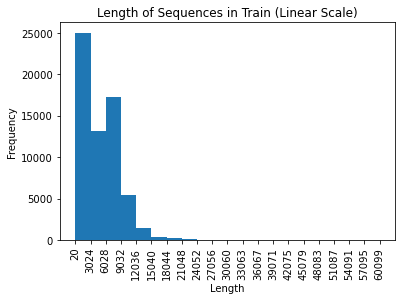

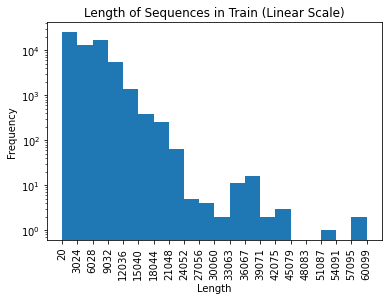

Minimum sequence length 20
Max sequence length 60099
Average sequence length 4839.025501055271


In [18]:
seq_lens = [len(seq) for seq in seqs]

make_hist(seq_lens, 20,
          title='Length of Sequences in Train (Linear Scale)',
          ylabel='Frequency',
          xlabel='Length')

make_hist(seq_lens, 20,
          title='Length of Sequences in Train (Linear Scale)',
          ylabel='Frequency',
          xlabel='Length',
          yscale='log')

print("Minimum sequence length", min(seq_lens))
print("Max sequence length", max(seq_lens))
print("Average sequence length", sum(seq_lens)/len(seq_lens))


Possible solutions: 
* Get more RAM (not guarenteed to work)
* Cut off all sequences to a particular value (but what?)
* Something else? What did others do?

#### Class Labels Histogram

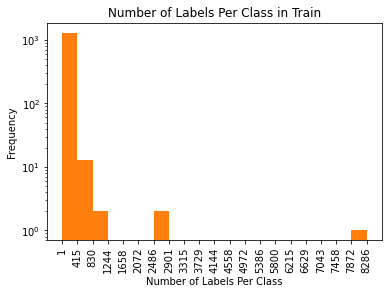

In [19]:
# get how many counts of label there are
label_to_counts = dict()
for label in labels:
  if label not in label_to_counts:
    label_to_counts[label] = 0
  label_to_counts[label] += 1

# get a list of label counts
counts = label_to_counts.values()

make_hist(counts, 20,
          title='Number of Labels Per Class in Train',
          ylabel='Frequency',
          xlabel='Number of Labels Per Class',
          yscale='log',
          color='C1')

### Tokenize Data

In [20]:
# seqs = seqs[:2]
# labels = labels[:2]

In [21]:
len(labels)

63017

In [33]:
def prep_data(seqs, cutoff_len=None):
    '''
    prepares data and returns train-dataloader and test_dataloader
    given the cutoff_len. If no cutoff_len is given, will not cut sequences.
    '''
    
    # cutting off sequences to given length
    if not cutoff_len is None:
        seqs = [seq[:cutoff_len] for seq in seqs]


    # tokenizing and getting a vocab
    tokenized_seqs, voc2ind = prepare_data(seqs)
    print("data prepared")

    # padding
    tokenized_seqs = pad(tokenized_seqs, voc2ind)
    print("tokenized sequenced")

    # tokenizing labels
    tokenized_labels, label2token = prepare_labels(labels)
    print('tokenized labels')

    print()

    # Showing the result of this:
    print("\n", tokenized_seqs, 
          "\n\n", voc2ind, 
          "\n\n", label_to_count(labels))

    # Train Test Split
    train_inputs, test_inputs, train_labels, test_labels = train_test_split(
        tokenized_seqs, tokenized_labels, test_size=0.1, random_state=42)

    # Load data to PyTorch DataLoader
    train_dataloader, test_dataloader = data_loader(train_inputs, test_inputs, 
                                                    train_labels, test_labels, 
                                                    batch_size=50)
    
    return train_dataloader, test_dataloader, seqs, voc2ind, tokenized_seqs, labels

In [23]:
# So you can now go choose what model you want!
STOP

NameError: name 'STOP' is not defined

## Model

In [ ]:
FEATURE_SIZE = tokenized_seqs.shape[1]

### Simple Model
This extremly simple neural network is to sanity check that the data has been processed correctly. Also if an extremly simple neural network with just a relu will classify output, that would also be great.

In [ ]:
FEATURE_SIZE = tokenized_seqs.shape[1]

class SimpleNet(nn.Module):
    def __init__(self, vocab_size, feature_size, num_classes):
        super(SimpleNet, self).__init__()
        # lenth of the vocabulary (number of words in the vocabulary)
        self.vocab_size = vocab_size
        # embeded_dim: Dimension of word vectors.
        self.feature_size = feature_size
        
        # encoder doesnt do anything and doesn't make much sense for this net
        # self.encoder = nn.Embedding(self.vocab_size, self.feature_size)

        self.fc1 = nn.Linear(feature_size, 1000)
        self.fc2 = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    


# Creating net and training
net = SimpleNet(len(voc2ind), FEATURE_SIZE, len(set(labels)))
losses = train(net, train_dataloader, epochs = 2)

# Evaluation
plot_losses(losses, title = "Splice Dataset: Convolutional Network Loss")
print_eval(net, train_dataloader, test_dataloader)
print()

In [ ]:
vocab_size = len(voc2ind)
feature_size = tokenized_seqs.shape[1]
print("vocab_size", vocab_size)
print("feautre_size", feature_size)
encoder = nn.Embedding(vocab_size, feature_size)

## Simple Net with Encoder

In [ ]:
FEATURE_SIZE = tokenized_seqs.shape[1]

class SimpleNet(nn.Module):
    def __init__(self, vocab_size, feature_size, num_classes):
        super(SimpleNet, self).__init__()
        # lenth of the vocabulary (number of words in the vocabulary)
        self.vocab_size = vocab_size
        # embeded_dim: Dimension of word vectors.
        self.feature_size = feature_size
        
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)

        self.fc1 = nn.Linear(feature_size ** 2, 1000)
        self.fc2 = nn.Linear(1000, num_classes)

    def forward(self, x):
        # The following line is required to send it through the encoder. 
        # because indexes are neccesary for use in the encoder
        # x = torch.tensor(x).to(torch.int64)
        x = x.clone().detach().requires_grad_(True).to(torch.int64)
        
    
        # Encode. 
        # Output shape: (b, max_len, embedded_dim)
        x = self.encoder(x)
        
        
        x = torch.flatten(x, 1)
        
        # print(self.feature_size)
        # print(x.shape)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    


# Creating net and training
net = SimpleNet(len(voc2ind), FEATURE_SIZE, len(set(labels)))
losses = train(net, train_dataloader, epochs = 5)

# Evaluation
plot_losses(losses, title = "Splice Dataset: Convolutional Network Loss")
print_eval(net, train_dataloader, test_dataloader)
print()

## CNN

DSC by CNN???

# Attempt at CNN

In [28]:
curr_cutoff = None

In [75]:
750//2

375

In [87]:
# experiments
# NOTE THAT in_channels_conv1 is always the seq_cutoff length
hyperparams = [
    # EXPERIMENT 0
    {'in_channels_conv1': 1000,     'out_channels_conv1': 300,
     'in_channels_conv2': 150,     'out_channels_conv2': 300,
     'in_channels_conv3': 150,     'out_channels_conv3': 300,
     'in_channels_fc1': 150,     'in_channels_fc2': 300, 
     'kernel_size': 20,     'stride': 20,
     'decay': 0.01,
     'epochs': 10,
     'train_acc': 0.33,     'test_acc': 0.33,     'time': None
    },
    
    # EXPERIMENT 1
    {'in_channels_conv1': 2000,     'out_channels_conv1': 600,
     'in_channels_conv2': 300,     'out_channels_conv2': 600,
     'in_channels_conv3': 300,     'out_channels_conv3': 600,
     'in_channels_fc1': 300,     'in_channels_fc2': 600, 
     'kernel_size': 20,     'stride': 20,
     'decay': 0.01,
     'epochs': 10,
     'train_acc': 0.36,     'test_acc': 0.34,     'time': "5hr"
    },  
    
    # EXPERIMENT 2
    {'in_channels_conv1': 1000,     'out_channels_conv1': 300,
     'in_channels_conv2': 150,     'out_channels_conv2': 75,
     'in_channels_conv3': 75//2,     'out_channels_conv3': 75//2,
     'in_channels_fc1': 38,     'in_channels_fc2': 300, 
     'kernel_size': 20,     'stride': 20,
     'decay': 0.01,
     'epochs': 10,
     'train_acc': 0.27,     'test_acc': 0.27,     'time': "1h 1m 40s"
    },
]

i = 2
hp = hyperparams[i]

In [83]:
if curr_cutoff is None or curr_cutoff != hp['in_channels_conv1']:
        train_dataloader, test_dataloader, new_seqs, voc2ind, tokenized_seqs, labels = prep_data(seqs, cutoff_len = hp['in_channels_conv1'])
        FEATURE_SIZE = tokenized_seqs.shape[1]
else:
    print('already prepared for this in_channels_conv1')
    
curr_cutoff = hp['in_channels_conv1']

already prepared for this in_channels_conv1


[1,   100] loss: 6.344
[1,   200] loss: 5.794
[1,   300] loss: 5.496
[1,   400] loss: 5.382
[1,   500] loss: 5.319
[1,   600] loss: 5.203
[1,   700] loss: 5.157
[1,   800] loss: 5.151
[1,   900] loss: 5.031
[1,  1000] loss: 4.977
[1,  1100] loss: 4.976
[2,   100] loss: 4.922
[2,   200] loss: 4.907
[2,   300] loss: 4.898
[2,   400] loss: 4.946
[2,   500] loss: 4.888
[2,   600] loss: 4.864
[2,   700] loss: 4.963
[2,   800] loss: 4.889
[2,   900] loss: 4.795
[2,  1000] loss: 4.761
[2,  1100] loss: 4.867
[3,   100] loss: 4.837
[3,   200] loss: 4.785
[3,   300] loss: 4.841
[3,   400] loss: 4.833
[3,   500] loss: 4.841
[3,   600] loss: 4.747
[3,   700] loss: 4.773
[3,   800] loss: 4.802
[3,   900] loss: 4.769
[3,  1000] loss: 4.831
[3,  1100] loss: 4.766
[4,   100] loss: 4.755
[4,   200] loss: 4.747
[4,   300] loss: 4.755
[4,   400] loss: 4.707
[4,   500] loss: 4.757
[4,   600] loss: 4.803
[4,   700] loss: 4.825
[4,   800] loss: 4.731
[4,   900] loss: 4.780
[4,  1000] loss: 4.774
[4,  1100] 

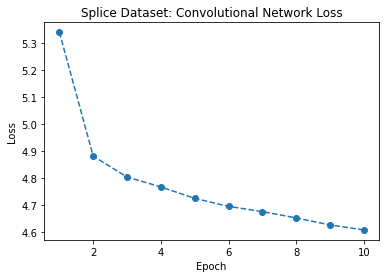

In [88]:
class DSC_by_CNN(nn.Module):
    def __init__(self, vocab_size, feature_size, num_classes):
        


        super(DSC_by_CNN, self).__init__()
        # Number of vocab words
        self.vocab_size = vocab_size
        # embeded_dim: Dimension of word vectors.
        self.feature_size = feature_size

        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        

        self.conv1 = nn.Conv1d(in_channels=hp['in_channels_conv1'],
                               out_channels=hp['out_channels_conv1'], 
                               kernel_size=hp['kernel_size'],
                               stride = hp['stride'],
                               padding = 1)
        
        self.conv2 = nn.Conv1d(in_channels=hp['in_channels_conv2'],
                               out_channels=hp['out_channels_conv2'], 
                               kernel_size=hp['kernel_size'],
                               stride = hp['stride'],
                               padding = 1)
        
        self.conv3 = nn.Conv1d(in_channels=hp['in_channels_conv3'],
                               out_channels=hp['out_channels_conv3'], 
                               kernel_size=hp['kernel_size'],
                               stride = hp['stride'],
                               padding = 1)

        # Activation
        self.act = nn.ReLU()

        # Pooling
        self.pool = nn.MaxPool2d(3, 2, 1)

        # fully connected layer
        self.fc1 = nn.Linear(hp['in_channels_fc1'], hp['in_channels_fc2'])
        self.fc2 = nn.Linear(hp['in_channels_fc2'], num_classes)

        # dropout
        self.drop = nn.Dropout(p=0.5)


    # seen in the network pytorch tutorial
    # I've been using this function for years, no idea what it does.
    # Would it kill the pytorch tutorial people to document this guy?
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features        


    def forward(self, x):
        # print("forward")
        # The following line is required to send it through the encoder. 
        # because indexes are neccesary for use in the encoder
        # x = torch.tensor(x).to(torch.int64)
        x = x.clone().detach().requires_grad_(True).to(torch.int64)
        
    
        # Encode. 
        # Output shape: (b, max_len, embedded_dim)
        x = self.encoder(x)
  
        # Permute shuffles dimensions. Do this to satisfy requirments of nn.Conv1d
        # Output shape: (b, embedded_dim, max_len)
        x = x.permute(0, 2, 1)

        # convolutional layer 1
        x = self.conv1(x)
        x = self.act(x)                         
        x = self.pool(x)

        # convolutional layer 2
        x = self.conv2(x)
        x = self.act(x)
        x = self.pool(x)
        
        # convolutional layer 3

        # flattening
        x = x.view(-1, self.num_flat_features(x))

        # Tring to figure out the shape
        #print(x.shape)

        # fully linear layer + dropout
        x = self.drop(x)
        # x = self.softm(x)
        x = self.fc1(x)
        
        # fully linear layer
        x = self.fc2(x)

        return x
    
start_time = time.time()
# Creating net and training
net = DSC_by_CNN(len(voc2ind), FEATURE_SIZE, len(set(labels)))
losses = train(net, train_dataloader, epochs=hp['epochs'], lr=0.01, decay = hp['decay'])


# Evaluation
plot_losses(losses, title = "Splice Dataset: Convolutional Network Loss")
print_eval(net, train_dataloader, test_dataloader)
print()

# time to complete
end_time = time.time()
print('Time to complete', time_str(end_time - start_time))